In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import dateutil.parser

In [2]:
color_list = [i for i in mcolors.TABLEAU_COLORS]
marker_list = ["o", "x"]
dataset = "fMRIQA_v2"

In [3]:
def time_converter(data, minute=False):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    if minute == True:
        return (d*24 + h)*60 + m + s/60
    return (((d*24 + h)*60+m)*60+s)/60

In [4]:
def memory_size_converter(size):
    giga = True
    if 'M' in size:
        giga = False
    num = float(size.rstrip('MnG'))
    if giga:
        return num*1024
    return num

In [5]:
def datetime_to_minutes(d):
    return d.seconds/60

# Correlate XNAT and ACCRE logs

In [26]:
# read XNAT logs
df = pd.read_excel('xnat_accre_full_stats.xlsx')

## 1. Identify the corresponding entries in the slurm logs

- Find the requirements of the given dataset
- Identify other applications that have the same resource requirements

In [7]:
# print requirements
df_requirements = df[df.proctype==dataset].groupby(
    ['ReqTRES', 'Timelimit']).size().reset_index(name='Freq')
df_requirements

,ReqTRES,Timelimit,Freq
0,"cpu=1,mem=4G,node=1",00:30:00,271
1,"cpu=1,mem=8G,node=1",01:00:00,653


In [8]:
df[(df.ReqTRES.isin(df_requirements.ReqTRES)) & (df.Timelimit.isin(df_requirements.Timelimit))]["proctype"].unique()

array(['fMRIQA_v2', 'fMRIQA_v3', 'NDW_VBM_v1',
       'fMRI_Connectivity_Process_Scan_v3'], dtype=object)

In [27]:
df['Timelimit'] = df['Timelimit'].astype(str)
df_apps = df[(df.ReqTRES == "cpu=1,mem=4G,node=1") & (df.Timelimit == "00:30:00")]
df_apps["proctype"].unique()

array(['fMRIQA_v2', 'fMRIQA_v3', 'fMRI_Connectivity_Process_Scan_v3'],
      dtype=object)

## 2. Create all the additional fields
- Walltime in min
- Used memory in MB
- Requested memory in MB
- Requested walltime in min

In addition add:
- Elapsed minutes since the first submission in the log

In [28]:
df['Timelimit_num'] = df['Timelimit'].astype(str)
df['Timelimit_num'] = df.Timelimit_num.apply(time_converter)
df['Walltime_num'] = df['Elapsed'].astype(str)
df['Walltime_num'] = df.Walltime_num.apply(time_converter)
df['ReqMem_num'] = df.ReqMem.apply(memory_size_converter)
df = df[df['memused'].notnull()].copy()
df['memused'] = df['memused'].astype(str)
df = df[df.memused.apply(lambda x: x.isnumeric())]
df['memused'] =  pd.to_numeric(df['memused']) / 1024

In [29]:
df['Submit_dt'] = df.Submit.apply(dateutil.parser.parse)
first_submission = df["Submit_dt"].values[0]

df["TimeFromOrigin"] = ((df['Submit_dt'] - first_submission) / np.timedelta64(1, 'm')).astype(int)
df[["TimeFromOrigin", "Submit"]].head()

,TimeFromOrigin,Submit
0,0,2018-01-01T15:01:37
1,59,2018-01-01T16:01:34
2,59,2018-01-01T16:01:34
3,59,2018-01-01T16:01:34
4,59,2018-01-01T16:01:34


# 3. Extract submissions from SLURM
- Following the same resource requirements as specified above

In [12]:
df_accre = pd.read_csv('MEM_COMPL_%s.csv' %(dataset), delimiter="|")

In [13]:
#df_accre = pd.read_csv('MEM_FAIL_%s.csv' %(dataset), delimiter="|")
df_accre['Timelimit_num'] = df_accre['Timelimit'].astype(str)
df_accre['Timelimit_num'] = df_accre.Timelimit_num.apply(time_converter)
df_accre['Walltime_num'] = df_accre['Elapsed'].astype(str)
df_accre['Walltime_num'] = df_accre.Walltime_num.apply(time_converter)
df_accre['ReqMem_num'] = df_accre.ReqMem.apply(memory_size_converter)
# df_accre contains only the failed runs due to memory exceed
df_accre['memused'] = df_accre['ReqMem_num']

In [14]:
df_accre['Submit_dt'] = df_accre.Submit.apply(dateutil.parser.parse)

df_accre["TimeFromOrigin"] = ((df_accre['Submit_dt'] - first_submission) / np.timedelta64(1, 'm')).astype(int)
df_accre.State.unique()

array(['COMPLETED', 'TIMEOUT', 'FAILED'], dtype=object)

In [15]:
print("Entries in XNAT:", len(df_apps))
print("Entries in ACCRE:", len(df_accre))
print("XNAT ids that are not in ACCRE:",
      len(df_apps[~df_apps.JobID.isin(df_accre.JobID)]))
print("ACCRE entries that are not in XNAT:",
      len(df_accre[~df_accre.JobID.isin(df_apps.JobID)]))

Entries in XNAT: 472
Entries in ACCRE: 618
XNAT ids that are not in ACCRE: 0
ACCRE entries that are not in XNAT: 146


- Plot timestamp entries for all entries in XNAT (color coded by application)
- Plot an additional color for all the entries that are only in ACCRE

fMRIQA_v2
fMRIQA_v3


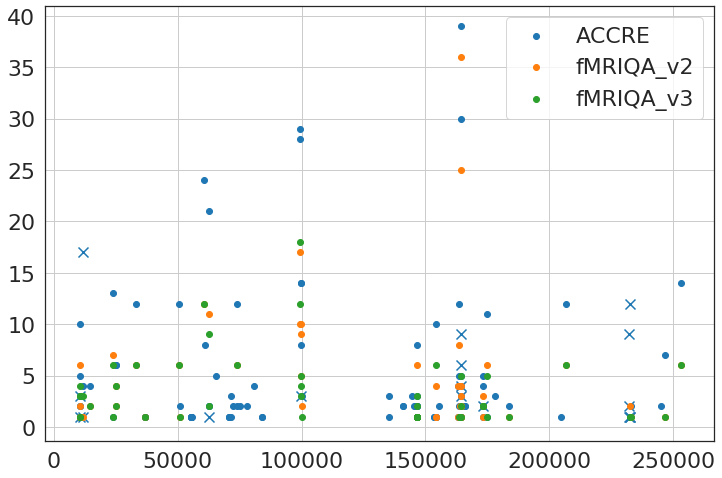

In [59]:
df_apps = df[(df.ReqTRES == "cpu=1,mem=4G,node=1") & (df.Timelimit == "00:30:00")]

sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,8))

cnt = 0
dfgroup = df_accre[df_accre.State=="COMPLETED"].groupby("TimeFromOrigin").count()["Submit"].reset_index()
ax.scatter(dfgroup["TimeFromOrigin"], dfgroup.Submit,
           color=color_list[cnt], label="ACCRE")
dfgroup = df_accre[df_accre.State=="TIMEOUT"].groupby("TimeFromOrigin").count()["Submit"].reset_index()
ax.scatter(dfgroup["TimeFromOrigin"], dfgroup.Submit,
           color=color_list[cnt], marker="x", s=100)

for app in df_apps["proctype"].unique():
    print(app)
    cnt += 1
    dfgroup = df_apps[df_apps.proctype==app].groupby("TimeFromOrigin").count()["id"].reset_index()
    
    ax.scatter(dfgroup["TimeFromOrigin"], dfgroup.id,
               color=color_list[cnt], label=app)

ax.legend()
plt.grid(True)
plt.show()

## 4. Analyze TIMEOUTS
- Find the submissions closest to each TIMEOUT batch

In [44]:
df_timeout = df_accre[df_accre.State=="TIMEOUT"][["JobID", "Submit", "TimeFromOrigin"]]
print(len(df_timeout))
#df_accre[df_accre.State=="TIMEOUT"].head()

76


In [19]:
df_timeout.groupby(
    ["TimeFromOrigin", "Submit"]).size().reset_index(name='Freq')

,TimeFromOrigin,Submit,Freq
0,10625,2018-01-09T00:06:37,2
1,10625,2018-01-09T00:07:16,1
2,10626,2018-01-09T00:08:01,1
3,11764,2018-01-09T19:06:21,1
4,11765,2018-01-09T19:07:04,3
5,11765,2018-01-09T19:07:05,2
6,11765,2018-01-09T19:07:15,12
7,62704,2018-02-14T04:06:03,1
8,99844,2018-03-11T23:06:21,1
9,99844,2018-03-11T23:06:22,2


In [20]:
input = 11764
min_time = df_apps.iloc[(df_apps["TimeFromOrigin"]-input).abs().argsort()][:1]["TimeFromOrigin"].min()
df_apps[df_apps.TimeFromOrigin == min_time][["State", "JobID", "proctype", "Submit", "TimeFromOrigin"]]

,State,JobID,proctype,Submit,TimeFromOrigin
1774,COMPLETED,23336315,fMRIQA_v3,2018-01-09T19:07:15,11765
1777,COMPLETED,23336320,fMRIQA_v3,2018-01-09T19:07:15,11765
1778,COMPLETED,23336316,fMRIQA_v2,2018-01-09T19:07:15,11765
1779,COMPLETED,23336299,fMRIQA_v3,2018-01-09T19:07:04,11765


# Get submission profile

In [67]:
df = df[(df.proctype=="fMRIQA_v2") | (df.proctype=="fMRIQA_v3")]
df.groupby(["ReqMem_num", "Timelimit_num"]).size().reset_index(name='Freq')

,ReqMem_num,Timelimit_num,Freq
0,4096.0,30.0,443
1,8192.0,60.0,648
2,10240.0,120.0,4


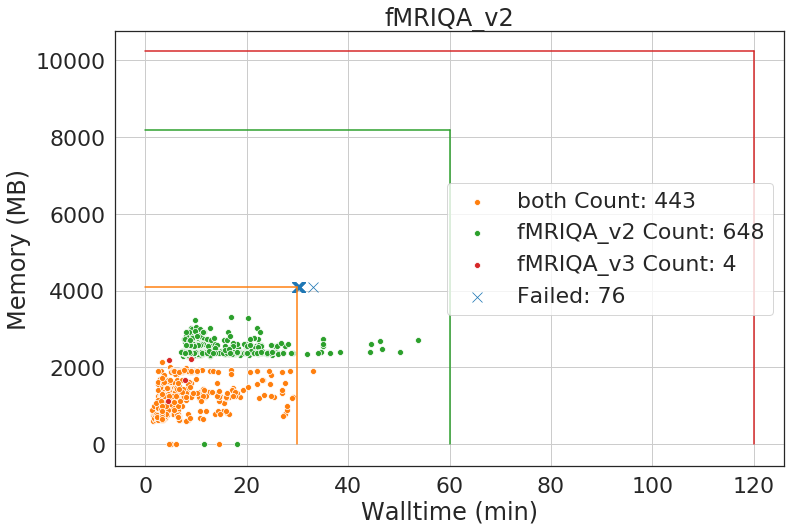

In [72]:
request = df[["ReqMem_num", "Timelimit_num"]].drop_duplicates()

fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

# set the request times
cnt = 1
for i in request.values:
    # time in database is in min
    plt.plot([i[1], i[1]], [0, i[0]], color=color_list[cnt])
    plt.plot([0, i[1]], [i[0], i[0]], color=color_list[cnt])
    app_running = df[(df.ReqMem_num == i[0]) & (df.Timelimit_num == i[1])]["proctype"].unique()
    if len(app_running) == 1:
        app_running = app_running[0]
    else:
        app_running = "both"
    sns.scatterplot(y="memused", x="Walltime_num", #marker=marker_list[cnt % 2],
                    data=df[(df.Timelimit_num == i[1]) & (df.ReqMem_num == i[0])],
                    color = color_list[cnt], label="%s Count: %d" %(
                        app_running,
                        len(df[(df.Timelimit_num == i[1]) & (df.ReqMem_num == i[0])])))
    cnt += 1
ax = sns.scatterplot(y="memused", x="Walltime_num",
                     data=df_accre[df_accre.State=="TIMEOUT"],
                     color = color_list[0], marker='x', s=100,
                     label="Failed: %d" %(len(df_accre[df_accre.State=="TIMEOUT"])))

plt.grid(True)
ax.set_xlabel('Walltime (min)')
ax.set_ylabel('Memory (MB)')
ax.set_title(dataset)
#ax.set_xscale('log', basex=2)
#ax.set_yscale('log', basey=2)

#plt.savefig("figures/time_fail_%s.png" %(dataset), bbox_inches = 'tight')
plt.show()